In [1]:
# Imports

import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
import os
from tqdm import tqdm
from torch import Tensor
import math
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/brock/anaconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/brock/anaconda3/envs/torch/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
##############################
#SEQUENCE PARAMETERS
##############################
VOCAB_SZ = 20 + 3
SRC_VOCAB_SIZE = VOCAB_SZ
TGT_VOCAB_SIZE = 2
BOS_IDX, EOS_IDX = 1, 2
MAX_LEN = 16
#############################


##############################
#TRAINING PARAMETERS
###############################
NUM_EPOCHS = 40
BATCH_SIZE = 128
EMB_SIZE = 128
LEARNING_RATE = 0.000052
DOWN_WEIGHT = 0.85
CUTOFF = 0.31
###############################

In [3]:
# Create Structures for Sequence Preprocessing
PAD_IDX = 'O'
AAs=np.array(list('WFGAVILMPYSTNQCKRHDE'))
curPath=os.getcwd()
AAidx_file='AAidx_PCA.txt' ## works like a charm!!!
gg=open(AAidx_file)
AAidx_Names=gg.readline().strip().split('\t')
AAidx_Dict={}
for ll in gg.readlines():
    ll=ll.strip().split('\t')
    AA=ll[0]
    tag=0
    vv=[]
    for xx in ll[1:]:
        vv.append(float(xx))
    if tag==1:
        continue
    AAidx_Dict[AA]=vv

AAidx_Dict["O"] = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Nf=len(AAidx_Dict['C'])
pre = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]).unsqueeze(0)
post = torch.tensor([2.0, 2.0,  2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]).unsqueeze(0)

In [4]:
def AAindexEncoding(Seq):
    Ns=len(Seq)
    AAE=np.zeros([Ns, Nf])
    for kk in range(Ns):
        ss=Seq[kk]
        AAE[kk,]=AAidx_Dict[ss]
    #AAE=np.transpose(AAE.astype(np.float32)) # When shape is 15x18
    AAE=AAE.astype(np.float32) # When shape is 18x15
    AAE = torch.from_numpy(AAE)
    return AAE

def vocab_transform(seq):
    assert len(seq) <= MAX_LEN
    t = []
    for a in seq:
        t.append(a)
    k = len(t) // 2
    t = t[:k] + [PAD_IDX]*(MAX_LEN-len(t)) + t[k:]
    return t

In [5]:
class AAsData(Dataset):
    def __init__(self, fn):
        d = pd.read_csv(fn, header=0, delimiter='\t')
        d = d.dropna()
        d = d[d['CDR3'].str.find('X') < 0]
        self.data = d
        self.weight  = np.ones(len(d))
        print('load data: %s, size=%d' % (fn.split('/')[-1], len(self.data)))
    


    def adjustWeights(self, model):
        
        _dataloader = DataLoader(self, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=False)
        
        cprobs=[]
        
        for i, (inputs, labels, weights) in enumerate(tqdm(_dataloader)):
          
            inputs = inputs.to(DEVICE)
            #print("input shape: ",inputs.shape)
            weights = weights.to(DEVICE)
            #print("labels shape: ",labels.shape)
            logits, softmaxOut = model(inputs)
            cancerProb = softmaxOut[:,1].detach().cpu().numpy()
            cprobs.append(cancerProb)
           
        cprobs=np.concatenate(cprobs)
        
        for i in range(len(cprobs)):
            if cprobs[i] < CUTOFF and self.data['Value'][i] == 1:
                self.weight[i] = self.weight[i] * DOWN_WEIGHT
        
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        d = self.data.iloc[item]
        return d['Value'], d['CDR3'], self.weight[item]

In [6]:
def collate_fn(data):
    labels, sequences, weights = [], [], []
    
    for label, sequence, weight in data:
        labels.append(label)
        weights.append(weight)
        result = AAindexEncoding(vocab_transform(sequence))
        temp = torch.cat((pre, torch.tensor(result), post))
        sequences.append(temp)
        
        
    weights = torch.FloatTensor(weights)
    labels = torch.IntTensor(labels)
    sequences = torch.stack(sequences)
    return sequences, labels, weights


In [7]:
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(0)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:,:token_embedding.size(1), :])



class CDRTransformer(nn.Module):
    def __init__(self, encoder_layer, num_layers, dropout: float = 0.1):
        super(CDRTransformer, self).__init__()
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.linear0 = nn.Linear(15, EMB_SIZE)
        self.linear = nn.Linear(EMB_SIZE, 2)
        self.positional_encoding = PositionalEncoding(
            EMB_SIZE, dropout=dropout)

    def forward(self, inputs):
        inputs = self.linear0(inputs)
        src_enc = self.positional_encoding(inputs)
        out = self.transformer_encoder(src_enc)
        out = self.linear(out)[:, 0]
        softOut = F.softmax(out, dim=-1)
        return out, softOut

In [8]:
encoder_layer = nn.TransformerEncoderLayer(d_model=EMB_SIZE, nhead=8, batch_first=True)
transformer = CDRTransformer(encoder_layer, num_layers = 3)
transformer = transformer.to(DEVICE)
optimizer = torch.optim.Adam(transformer.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.98), eps=1e-9) # orig 0.00009

In [9]:
def softAccuracy(true_labels, pred_labels):
    #print("tru..",  true_labels.view(-1).float().shape)
    #print("pred.. ", pred_labels.float().shape)
    #print(pred_labels.float())
    accuracy = torch.sum(true_labels.view(-1).float() == pred_labels.float()) / BATCH_SIZE
    return accuracy.item()

train_iter = AAsData('TrainingData/train_data.tsv')
def train_epoch(model, optimizer, epoch):
    model.train()
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)

    losses = 0
    acc = 0
    total = 0


            
    all_logits = torch.Tensor([]).to(DEVICE)
    all_labels = torch.Tensor([]).to(DEVICE)
    for i, (inputs, labels, weights) in enumerate(tqdm(train_dataloader)):
        total += 1
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        #print("input shape: ",inputs.shape)
        weights = weights.to(DEVICE)
        #print("labels shape: ",labels.shape)
        logits, softlogits = model(inputs)
        
        #print(logits.shape)
        #print(softlogits.shape)
        acc += softAccuracy(labels, torch.argmax(logits, dim=1))
        optimizer.zero_grad()

        labels = labels.type(torch.LongTensor).to(DEVICE)
        all_labels = torch.cat((all_labels, labels))
        all_logits = torch.cat((all_logits, logits))  
        # logits = logits.float().to(DEVICE)

        loss = nn.CrossEntropyLoss(reduction='none')(logits, labels)
        loss = torch.mean(loss * weights)
        
        loss.backward()
        optimizer.step()
        losses += loss.item()
    
    if (epoch % 10) == 0 and epoch != 0:
        ## PLOT IT
        count = 1
        plt.subplots_adjust(hspace=.5)
        for filename in os.listdir("TrainingData/Split"):
            f = os.path.join("TrainingData/Split", filename)
            out = evaluate_cancer(model, f)
            ScoreDict = out.detach().cpu().numpy()
            out = filename + "," + str(out[1].item()) + '\n'
            print("File Number ", count)
        
            # PLot Socres
            plt.subplot(2, 2, count)
            plt.title(filename) 
            #plt.xlabel("Sequences") 
            #plt.ylabel("CancerScores") 
            plt.hist(ScoreDict, 50) 
            count+=1
    
        plt.show()
    
    out = acc / total
    print("Training Accuracy: ", out)

    return losses, out

def downweight(model): 
    train_iter.adjustWeights(model)

def cancer_score(X):
    X = F.softmax(X, dim=1)
    length = len(X)
    X = torch.sum(X, axis =0)
    return X / length

def evaluate(model, roc= False):
    model.eval()
    losses = 0
    val_iter = AAsData('TrainingData/testing_data.tsv')
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)
    acc = 0
    total = 0
    for i, (inputs, labels, weights) in enumerate(tqdm(val_dataloader)):
        total += 1
        inputs = inputs.to(torch.float32).to(DEVICE)
        labels = labels.to(torch.float32).to(DEVICE)
        logits, softlogits = model(inputs)
        acc += softAccuracy(labels, torch.argmax(logits, dim=1))
        
        labels = labels.type(torch.LongTensor).to(DEVICE)
        #logits = logits.float().to(DEVICE)

        loss = nn.CrossEntropyLoss()(logits, labels)
        losses += loss.item()
    out = acc/total
    print("Evaluation Accuracy: " , out)
    return (losses / len(val_dataloader)), out

def evaluate_cancer(model, file):
    model.eval()
    losses = 0

    val_iter = AAsData(file)
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=False)

    all_logits = torch.Tensor([]).to(DEVICE)
    all_labels = torch.Tensor([]).to(DEVICE)

    for i, (inputs, labels, weights) in enumerate(tqdm(val_dataloader)):
        inputs = inputs.to(torch.float32).to(DEVICE)
        #labels = labels.to(torch.float32).to(DEVICE)
        logits, _ = model(inputs)
        #all_labels = torch.cat((all_labels, labels))
        if i < 30:
            all_logits = torch.cat((all_logits, logits))
        

    
    #labels = all_labels.cpu().detach().numpy()
    out = F.softmax(all_logits, dim=1)[:,1]
    #out = cancer_score(logits)
    #print(index_list)
    print("\nCancer Score: ", out, '\n')
    return out

load data: train_data.tsv, size=65046


In [10]:
outfile = open("output.txt", 'w')
train_acc = np.array([])
eval_acc = np.array([])
best_acc = 0.0

In [14]:
NUM_EPOCHS = 28
for epoch in range(NUM_EPOCHS):
    print("Epoch: ", epoch)
    train_loss, acc = train_epoch(transformer, optimizer, epoch)
    train_acc = np.append(train_acc, acc)
    print(train_loss)
    if epoch % 10 == 0 and epoch != 0: 
        val_loss, acc = evaluate(transformer)
        downweight(transformer)
        eval_acc = np.append(eval_acc, acc)
        #print(val_loss)
    if epoch % 1 == 0 :#:
        torch.save(transformer.state_dict(), 'SavedModels/classifier.pt.s%d' % epoch)

Epoch:  0


  0%|                                                   | 0/509 [00:00<?, ?it/s]/tmp/ipykernel_88476/2204211413.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  temp = torch.cat((pre, torch.tensor(result), post))
100%|█████████████████████████████████████████| 509/509 [00:09<00:00, 54.84it/s]


Training Accuracy:  0.6829414292730844
303.4505788087845
Epoch:  1


100%|█████████████████████████████████████████| 509/509 [00:08<00:00, 56.94it/s]


Training Accuracy:  0.6912143909626719
298.7936951518059
Epoch:  2


100%|█████████████████████████████████████████| 509/509 [00:09<00:00, 56.55it/s]


Training Accuracy:  0.6998710707269156
293.754152148962
Epoch:  3


100%|█████████████████████████████████████████| 509/509 [00:08<00:00, 56.88it/s]


Training Accuracy:  0.7046598722986247
290.02147275209427
Epoch:  4


100%|█████████████████████████████████████████| 509/509 [00:08<00:00, 57.05it/s]


Training Accuracy:  0.7108607563850687
286.93329575657845
Epoch:  5


100%|█████████████████████████████████████████| 509/509 [00:08<00:00, 57.09it/s]


Training Accuracy:  0.7157569990176817
283.58271712064743
Epoch:  6


100%|█████████████████████████████████████████| 509/509 [00:08<00:00, 56.99it/s]


Training Accuracy:  0.7194406925343811
281.013950496912
Epoch:  7


100%|█████████████████████████████████████████| 509/509 [00:08<00:00, 56.76it/s]


Training Accuracy:  0.7209909135559921
279.2335444390774
Epoch:  8


100%|█████████████████████████████████████████| 509/509 [00:08<00:00, 57.00it/s]


Training Accuracy:  0.7212364931237721
277.66646245121956
Epoch:  9


100%|█████████████████████████████████████████| 509/509 [00:08<00:00, 56.95it/s]


Training Accuracy:  0.7255801817288802
275.96406427025795
Epoch:  10


100%|█████████████████████████████████████████| 509/509 [00:08<00:00, 57.19it/s]


KeyError: 'CDR3'

<Figure size 432x288 with 0 Axes>

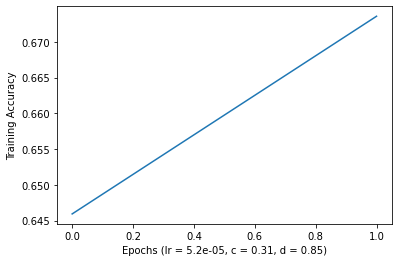

In [12]:
plt.xlabel("Epochs (lr = " + str(LEARNING_RATE) + ", c = " + str(CUTOFF) + ", d = " + str(DOWN_WEIGHT) + ")")
plt.ylabel("Training Accuracy") 
plt.plot(train_acc)
plt.show()

torch.save(transformer.state_dict(), 'SavedModels/classifier.pt')      

In [13]:
#transformer.load_state_dict(torch.load("savedModels/classifier.pt", map_location=torch.device('cpu')))

for i in range(0, 5):
    if i == 0:
        ds = 'Stromnes'
        dirt = "Cancer/"
        target = "Cancer/" + ds
    if i == 1:
        ds = 'Beausang'
        dirt = "Cancer/"
        target = "Cancer/" + ds
    if i == 2:
        ds = 'Robert'
        dirt = "Cancer/"
        target = "Cancer/" + ds
    if i == 3:
        ds = 'Emerson'
        dirt = "Cancer/"
        target = "Cancer/" + ds
    if i == 4:
        ds = 'EmersonC'
        dirt = "Control/"
        target = "Control/" + ds

    file = open(dirt + "Cancer_score_" + ds +".csv", "w+")

    print(torch.cuda.is_available())

    plt.subplots_adjust(hspace=.5)

    file.write("File,Score\n")
    count = 1
    for filename in os.listdir(target):
        f = os.path.join(target, filename)
        out = evaluate_cancer(transformer, f)
        ScoreDict = out.detach().cpu().numpy()
        out = filename + "," + str(out[1].item()) + '\n'
        print("File Number ", count)
        count +=1
        '''
        # PLot Socres
        plt.subplot(2, 2, count)
        plt.title(f) 
        #plt.xlabel("Sequences") 
        #plt.ylabel("CancerScores") 
        plt.hist(ScoreDict, 50) 
        count+=1
        '''

        file.write(out)

    #plt.show()

    file.close()

df = pd.read_csv('Cancer/Cancer_score_Beausang.csv', low_memory=False) # ES BC
df1 = pd.read_csv('Cancer/Cancer_score_Emerson.csv', low_memory=False) # Ovarian
df2 = pd.read_csv('Cancer/Cancer_score_Robert.csv', low_memory=False) #  Melanoma
df3 = pd.read_csv('Cancer/Cancer_score_Stromnes.csv', low_memory=False) # Pancreas
df4 = pd.read_csv('Control/Cancer_score_EmersonC.csv', low_memory=False)


breast = df['Score'].values
ovarian = df1['Score'].values
melanoma = df2['Score'].values
pancreas = df3['Score'].values
control = df4['Score'].values

y_true = np.ones(len(breast))
y_true2 = np.zeros(len(control))

x = np.concatenate([breast, control])
y = np.concatenate([y_true, y_true2])


print("Beausang (BC): ", roc_auc_score(y, x))
x = np.concatenate([ovarian, control])
y_true = np.ones(len(ovarian))
y = np.concatenate([y_true, y_true2])
print("Emerson (Ovar): ", roc_auc_score(y, x))
x = np.concatenate([melanoma, control])
y_true = np.ones(len(melanoma))
y = np.concatenate([y_true, y_true2])
print("Stromnes (Mel)): ", roc_auc_score(y, x))
x = np.concatenate([pancreas, control])
y_true = np.ones(len(pancreas))
y = np.concatenate([y_true, y_true2])
print("Robert (Panc): ", roc_auc_score(y, x))


True
load data: TestReal-PC19-55Blood.tsv, size=8433


  0%|                                                    | 0/66 [00:00<?, ?it/s]/tmp/ipykernel_88476/2204211413.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  temp = torch.cat((pre, torch.tensor(result), post))
100%|███████████████████████████████████████████| 66/66 [00:00<00:00, 74.79it/s]



Cancer Score:  tensor([0.1677, 0.3152, 0.2590,  ..., 0.7944, 0.7510, 0.4088], device='cuda:0',
       grad_fn=<SelectBackward0>) 

File Number  1
load data: TestReal-PC19-16Blood.tsv, size=1707


  0%|                                                    | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_88476/2204211413.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  temp = torch.cat((pre, torch.tensor(result), post))
100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 64.86it/s]



Cancer Score:  tensor([0.1438, 0.2366, 0.3729,  ..., 0.2800, 0.4045, 0.1722], device='cuda:0',
       grad_fn=<SelectBackward0>) 

File Number  2
load data: TestReal-PC19-40Blood.tsv, size=7097


  0%|                                                    | 0/56 [00:00<?, ?it/s]/tmp/ipykernel_88476/2204211413.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  temp = torch.cat((pre, torch.tensor(result), post))
100%|███████████████████████████████████████████| 56/56 [00:00<00:00, 75.16it/s]



Cancer Score:  tensor([0.2588, 0.2728, 0.4272,  ..., 0.1848, 0.1805, 0.4432], device='cuda:0',
       grad_fn=<SelectBackward0>) 

File Number  3
load data: TestReal-PC19-39Blood.tsv, size=8347


  0%|                                                    | 0/66 [00:00<?, ?it/s]/tmp/ipykernel_88476/2204211413.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  temp = torch.cat((pre, torch.tensor(result), post))
100%|███████████████████████████████████████████| 66/66 [00:00<00:00, 78.36it/s]



Cancer Score:  tensor([0.4365, 0.3155, 0.1304,  ..., 0.7687, 0.1920, 0.4213], device='cuda:0',
       grad_fn=<SelectBackward0>) 

File Number  4
load data: TestReal-PC19-44Blood.tsv, size=8585


  0%|                                                    | 0/68 [00:00<?, ?it/s]/tmp/ipykernel_88476/2204211413.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  temp = torch.cat((pre, torch.tensor(result), post))
100%|███████████████████████████████████████████| 68/68 [00:00<00:00, 79.13it/s]



Cancer Score:  tensor([0.2915, 0.1495, 0.1041,  ..., 0.1076, 0.5396, 0.2306], device='cuda:0',
       grad_fn=<SelectBackward0>) 

File Number  5
load data: TestReal-PC19-68Blood.tsv, size=8463


  0%|                                                    | 0/67 [00:00<?, ?it/s]/tmp/ipykernel_88476/2204211413.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  temp = torch.cat((pre, torch.tensor(result), post))
100%|███████████████████████████████████████████| 67/67 [00:00<00:00, 79.37it/s]



Cancer Score:  tensor([0.2870, 0.1717, 0.2157,  ..., 0.8511, 0.6432, 0.0774], device='cuda:0',
       grad_fn=<SelectBackward0>) 

File Number  6
load data: TestReal-PC19-64Blood.tsv, size=8615


  0%|                                                    | 0/68 [00:00<?, ?it/s]/tmp/ipykernel_88476/2204211413.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  temp = torch.cat((pre, torch.tensor(result), post))
100%|███████████████████████████████████████████| 68/68 [00:00<00:00, 77.74it/s]



Cancer Score:  tensor([0.4789, 0.1551, 0.1357,  ..., 0.5217, 0.1479, 0.3807], device='cuda:0',
       grad_fn=<SelectBackward0>) 

File Number  7
True
load data: TestReal-BR13B.tsv, size=8831


  0%|                                                    | 0/69 [00:00<?, ?it/s]/tmp/ipykernel_88476/2204211413.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  temp = torch.cat((pre, torch.tensor(result), post))
 99%|██████████████████████████████████████████▍| 68/69 [00:00<00:00, 77.14it/s]


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>